# GDSC Volunteer Program 
## TensorFlow Task

## Author: Anirudh Roy

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf

### Loading the dataset

In [41]:
header = ['user_id','proj_id','rating','timestamp']
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
dataset = pd.read_csv(url , sep = '\t', names = header)
dataset.head()

,user_id,proj_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [42]:
dataset.shape

(100000, 4)

In [44]:
dataset.describe()

,user_id,proj_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [46]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values #tensorflow only takes object type data
dataset.proj_id = dataset.proj_id.astype('category').cat.codes.values #thus converting the data into category

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [48]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [49]:
n_users, n_project = len(dataset.user_id.unique()), len(dataset.proj_id.unique())
n_latent_factors = 20 #the output dimension of our matrix

### Defining Layers

In [51]:
proj_input = keras.layers.Input(shape=[1],name='Item')
proj_embedding = keras.layers.Embedding(n_project + 1, n_latent_factors, name='Project-Embedding')(proj_input)
proj_vec = keras.layers.Flatten(name='Flattenproject')(proj_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.dot([proj_vec, user_vec], axes=1,name='DotProduct')
model = keras.Model([user_input, proj_input], prod)

In [52]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [53]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Project-Embedding (Embedding)   (None, 1, 20)        33660       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
____________________________________________________________________________________________

In [54]:
history = model.fit([train.user_id, train.proj_id], train.rating, epochs=100, verbose=0)

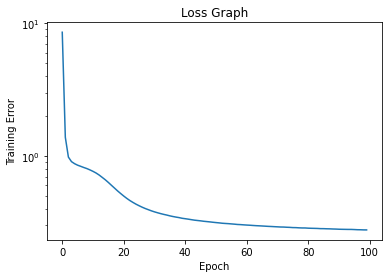

In [55]:
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.title('Loss Graph')
plt.show()

In [56]:
results = model.evaluate((test.user_id, test.proj_id), test.rating, batch_size=1)

20000/20000 [==============================] - 22s 1ms/step - loss: 1.6191 - mae: 0.9578 - mse: 1.6191


In [64]:
proj_embedding_learnt = model.get_layer(name='Project-Embedding').get_weights()[0] #weights are requested from the layer to sort the projects priority wise 
a = pd.DataFrame(proj_embedding_learnt)
a.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.547174,0.509055,0.648635,-0.418492,0.895591,-0.308743,-0.672795,0.075166,0.893911,-0.558261,-0.586524,-0.002567,0.195712,0.635819,0.389228,0.121805,-0.314645,0.458542,-0.297101,-0.412626
1,-0.125139,0.221336,0.288484,-0.047124,0.837882,0.312225,-0.635870,0.519100,0.577786,-0.290671,-0.323865,-0.619502,0.800625,-0.069065,0.251750,0.753345,-0.462276,0.405432,-0.356053,-0.493657
2,0.628706,0.281775,0.880364,-0.539777,-0.495326,-0.521591,-1.021580,1.854807,-0.273267,-0.161818,-0.404437,0.352308,-1.034721,0.144102,0.271016,0.480394,-0.381646,1.168822,-0.285324,0.049080
3,0.262080,0.702853,0.703895,-0.399099,0.763560,-0.447217,-0.664026,0.457554,-0.515202,-0.466916,-0.262809,-0.044884,0.669100,0.669401,0.323919,1.400005,-0.152285,0.221528,-0.014127,-0.268817
4,0.296562,0.108524,0.588010,-0.116044,-0.132763,0.402561,-0.090261,-0.159824,0.332803,-0.547188,-0.546061,-0.648994,0.679717,0.984817,0.418738,0.185552,-0.456459,1.656982,-0.766295,-0.791347


In [58]:
a.shape

(1683, 20)

In [63]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0] #weights are requested from the layer to sort the projects priority wise 
b = pd.DataFrame(user_embedding_learnt)
b.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.473077,0.388023,0.045932,-0.904564,0.828103,-0.262708,-1.041786,0.810119,0.349255,-0.308737,-0.204084,-0.574841,0.178412,-0.318575,0.776274,0.163858,-0.123873,0.804762,0.629090,-0.417708
1,0.779446,0.271635,-0.252435,-0.679420,0.444689,-0.482381,-0.292258,-0.014695,1.253357,0.006927,-1.721620,-0.143833,1.045808,0.563418,0.780417,-0.280913,-0.166479,0.774376,0.415225,-0.135111
2,0.422434,0.922233,-1.190999,-0.668052,0.155969,-0.378354,-0.092287,-0.350082,-0.090835,-0.509305,0.049393,-1.745769,0.448625,0.578177,1.123604,-0.677254,-0.575619,0.549785,0.292683,-1.257865
3,-0.536091,1.759932,0.012384,0.683764,1.188860,-1.599597,-0.020172,0.119257,1.667030,-0.873227,-0.628197,-0.176716,-0.670547,0.207622,0.321281,-0.197661,-1.900351,0.687470,-0.769733,-0.479670
4,0.612028,1.329091,0.744430,-0.151655,0.005926,-0.345013,-1.431413,0.390897,0.208481,0.096059,1.139837,-0.868713,0.302651,0.162721,1.514264,0.329560,-1.100013,-0.652620,0.262338,-0.739228


In [60]:
b.shape

(944, 20)

Recommending the project ID number to the specific user (upto top 5 recommendations)

In [61]:
def recommend(user_id, number_of_proj=5):
  projects = user_embedding_learnt[user_id]@proj_embedding_learnt.T #"@" means matrix multiplication, T is transpose
  mids = np.argpartition(projects, -number_of_proj)[-number_of_proj:] #only showing 5 recommendation and not repeating that
  return mids

In [62]:
recommend(user_id=2) #the user id can be changed

array([ 136, 1072,  936,  615,  371])